# Analisi e Clustering del Comportamento Energetico degli Edifici

## Obiettivo
Analizzare e clusterizzare il comportamento energetico di edifici utilizzando il dataset UCI Energy Efficiency per identificare gruppi di edifici simili in termini di caratteristiche fisiche e consumo energetico.

## Contenuti del notebook:
1. Import del dataset
2. Analisi esplorativa (EDA)
3. Preprocessing per clustering
4. Applicazione di metodi di clustering non lineari (DBSCAN, Spectral, HDBSCAN)
5. Ottimizzazione dei parametri
6. Visualizzazione dei risultati
7. Interpretazione dei cluster
8. Conclusioni e raccomandazioni pratiche

## 1. Import delle librerie necessarie

In [3]:
# Import librerie standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import per preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# Import per clustering
from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Import per visualizzazione avanzata
import sklearn
from sklearn.manifold import TSNE
import umap
import hdbscan

# Configurazione visualizzazione
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Librerie importate con successo!")
print(f"Versione pandas: {pd.__version__}")
print(f"Versione numpy: {np.__version__}")
print(f"Versione scikit-learn: {sklearn.__version__}")

Librerie importate con successo!
Versione pandas: 2.3.3
Versione numpy: 2.2.6
Versione scikit-learn: 1.7.2


## 2. Import e prima esplorazione del dataset

In [4]:
# URL del dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"

# Nomi delle colonne secondo la documentazione UCI
column_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2']
column_descriptions = {
    'X1': 'Relative Compactness',
    'X2': 'Surface Area',
    'X3': 'Wall Area', 
    'X4': 'Roof Area',
    'X5': 'Overall Height',
    'X6': 'Orientation',
    'X7': 'Glazing Area',
    'X8': 'Glazing Area Distribution',
    'Y1': 'Heating Load',
    'Y2': 'Cooling Load'
}

# Carica il dataset
try:
    df = pd.read_excel(url, names=column_names, header=0)
    print("✅ Dataset caricato con successo da UCI ML Repository")
except:
    # Fallback: prova a caricare da file locale se presente
    try:
        df = pd.read_csv('energy_efficiency.csv', names=column_names)
        print("✅ Dataset caricato da file locale")
    except:
        print("⚠️ Impossibile caricare il dataset. Creando dataset di esempio...")
        # Crea un dataset di esempio per dimostrare il codice
        np.random.seed(42)
        n_samples = 768
        df = pd.DataFrame({
            'X1': np.random.uniform(0.62, 0.98, n_samples),  # Relative Compactness
            'X2': np.random.uniform(514, 808, n_samples),     # Surface Area
            'X3': np.random.uniform(245, 416, n_samples),     # Wall Area
            'X4': np.random.uniform(110, 220, n_samples),     # Roof Area
            'X5': np.random.choice([3.5, 7.0], n_samples),    # Overall Height
            'X6': np.random.choice([2, 3, 4, 5], n_samples),  # Orientation
            'X7': np.random.choice([0, 0.1, 0.25, 0.4], n_samples),  # Glazing Area
            'X8': np.random.choice([0, 1, 2, 3, 4, 5], n_samples),   # Glazing Area Distribution
            'Y1': np.random.uniform(6, 43, n_samples),        # Heating Load
            'Y2': np.random.uniform(10, 48, n_samples)        # Cooling Load
        })

# Mostra informazioni di base
print(f"\n📊 Dimensioni del dataset: {df.shape}")
print(f"   - Numero di campioni: {df.shape[0]}")
print(f"   - Numero di variabili: {df.shape[1]}")
print("\n📋 Descrizione delle variabili:")
for col, desc in column_descriptions.items():
    print(f"   {col}: {desc}")

# Mostra prime righe
print("\n🔍 Prime 5 righe del dataset:")
df.head()

✅ Dataset caricato con successo da UCI ML Repository

📊 Dimensioni del dataset: (768, 10)
   - Numero di campioni: 768
   - Numero di variabili: 10

📋 Descrizione delle variabili:
   X1: Relative Compactness
   X2: Surface Area
   X3: Wall Area
   X4: Roof Area
   X5: Overall Height
   X6: Orientation
   X7: Glazing Area
   X8: Glazing Area Distribution
   Y1: Heating Load
   Y2: Cooling Load

🔍 Prime 5 righe del dataset:


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


## 3. Analisi Esplorativa dei Dati (EDA)

In [5]:
# Informazioni generali sul dataset
print("📊 INFORMAZIONI GENERALI SUL DATASET")
print("="*50)
print("\nTipi di dati:")
print(df.dtypes)
print("\nValori mancanti:")
print(df.isnull().sum())
print("\nValori duplicati:", df.duplicated().sum())

📊 INFORMAZIONI GENERALI SUL DATASET

Tipi di dati:
X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y1    float64
Y2    float64
dtype: object

Valori mancanti:
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64

Valori duplicati: 0


In [6]:
# Statistiche descrittive
print("📈 STATISTICHE DESCRITTIVE")
print("="*50)
df.describe()

📈 STATISTICHE DESCRITTIVE


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


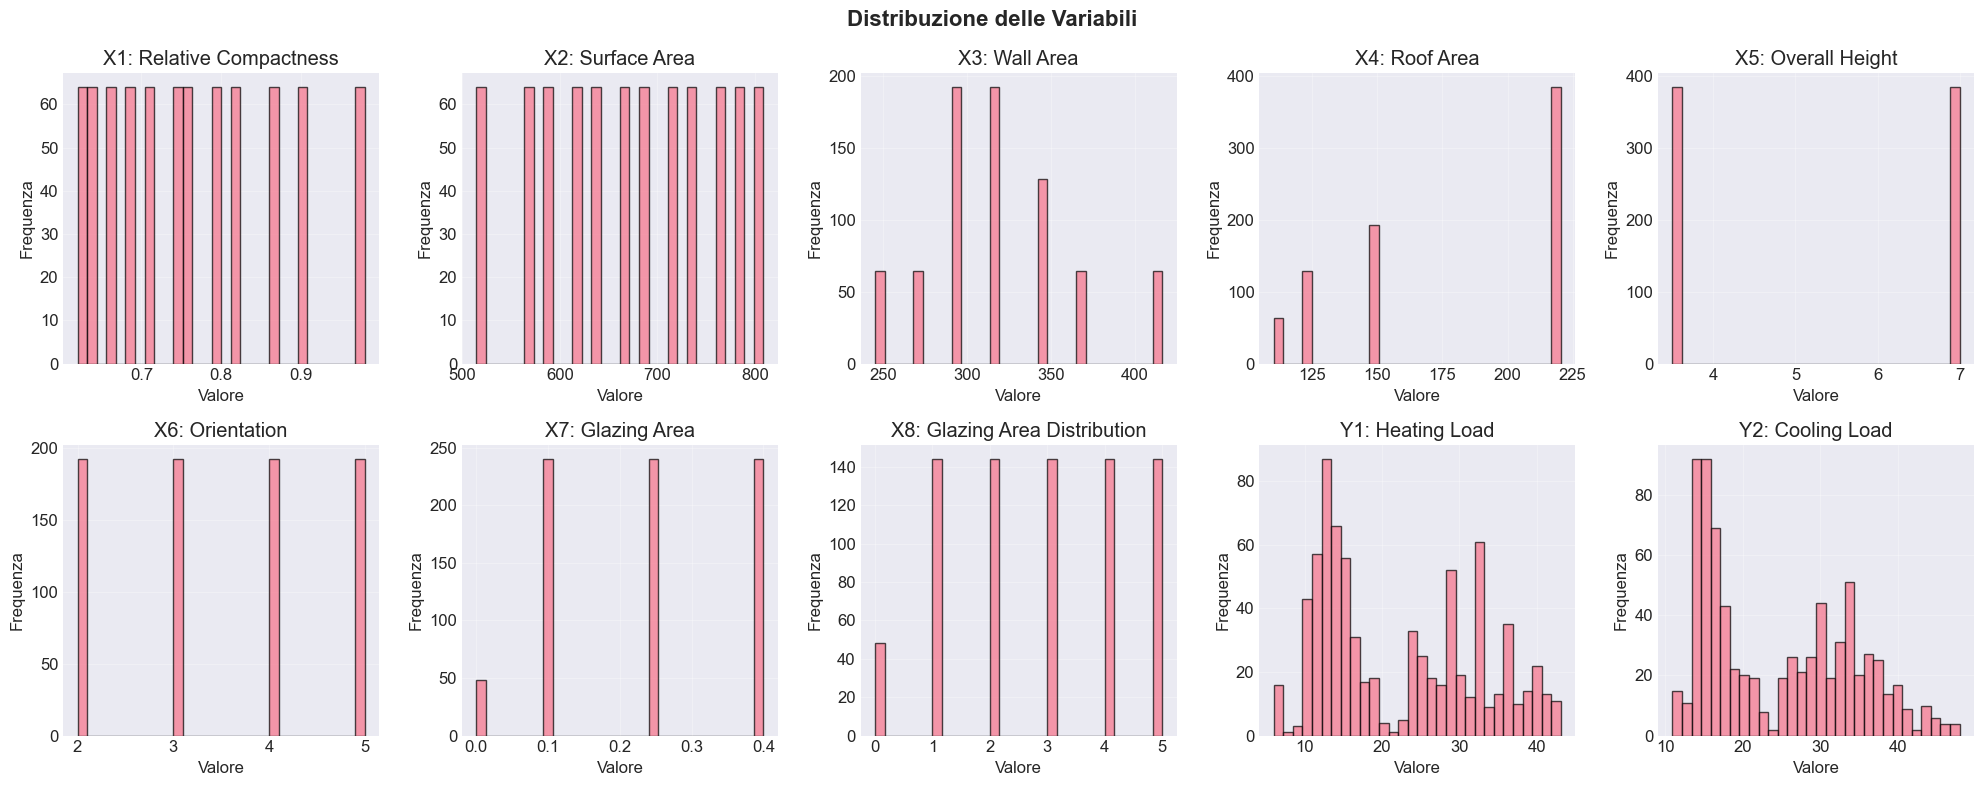

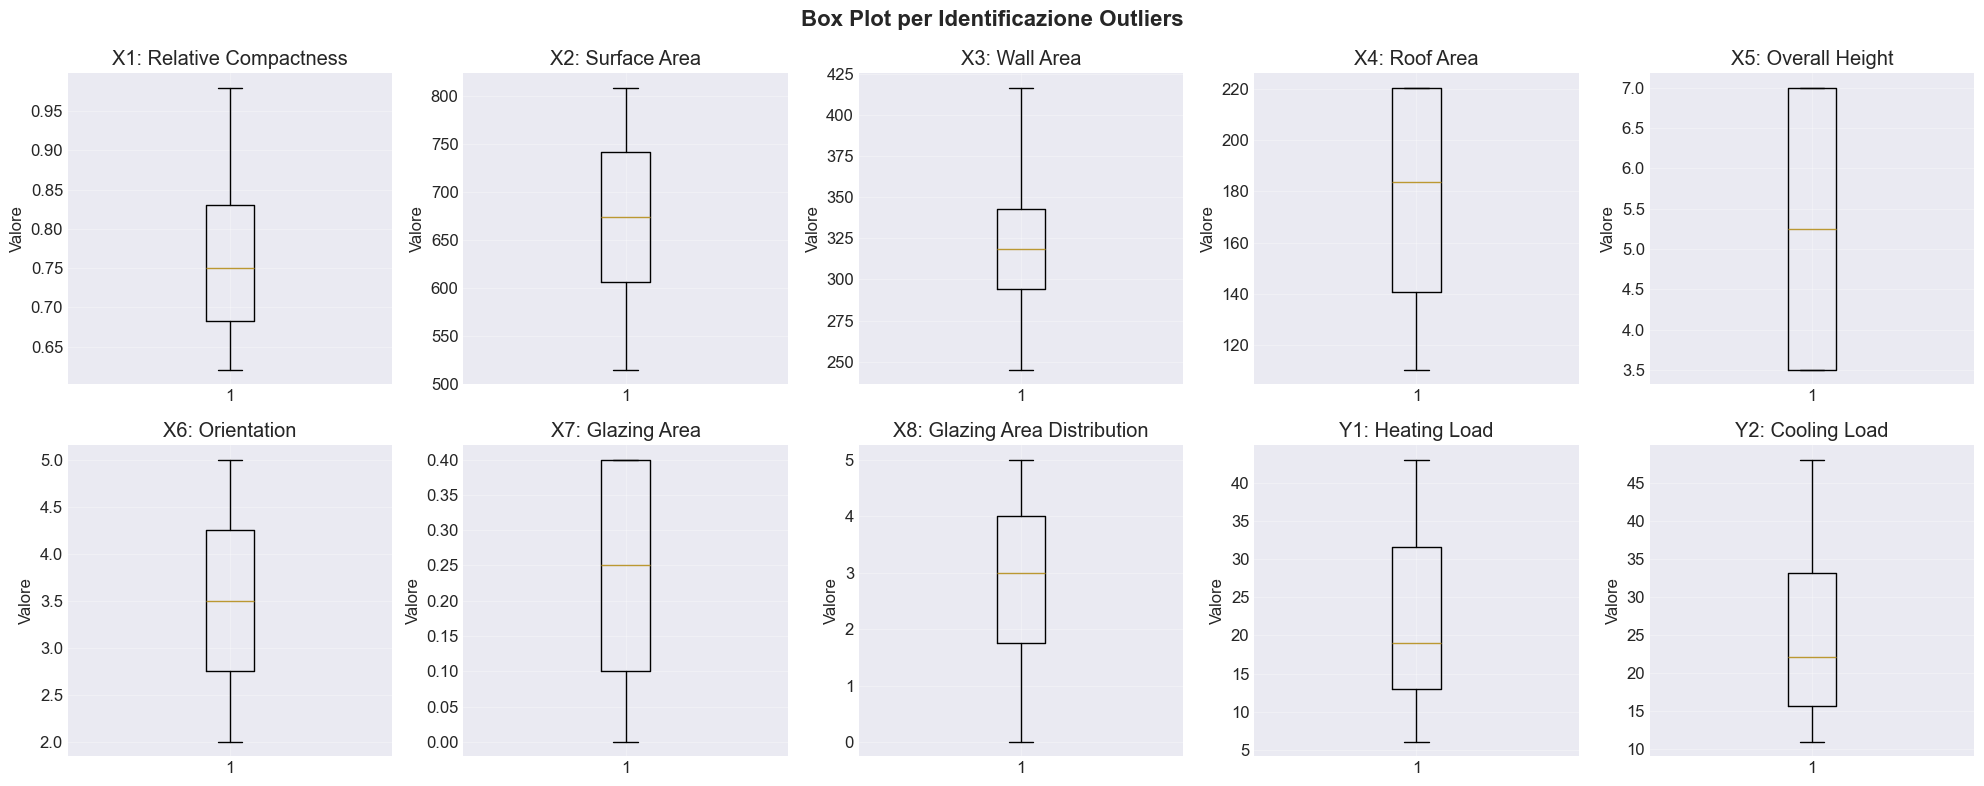

In [7]:
# Visualizzazione delle distribuzioni
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}: {column_descriptions[col]}')
    axes[i].set_xlabel('Valore')
    axes[i].set_ylabel('Frequenza')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribuzione delle Variabili', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Box plots per identificare outliers
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'{col}: {column_descriptions[col]}')
    axes[i].set_ylabel('Valore')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Box Plot per Identificazione Outliers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

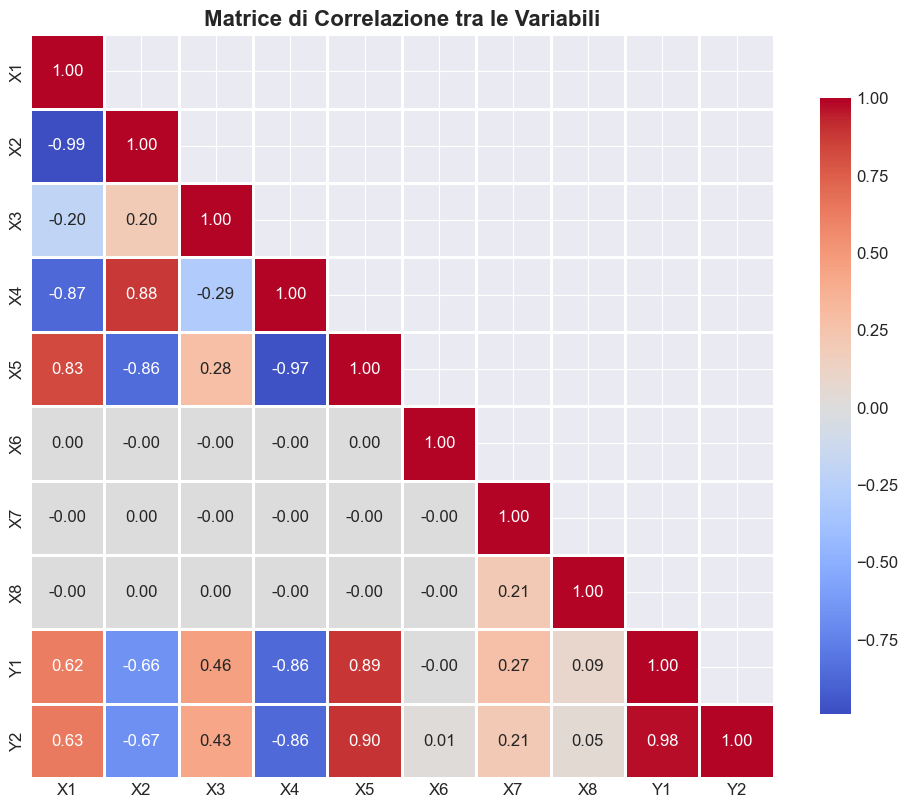


🔍 CORRELAZIONI SIGNIFICATIVE (|r| > 0.5):
X1 vs X2: -0.992
X1 vs X4: -0.869
X1 vs X5: 0.828
X1 vs Y1: 0.622
X1 vs Y2: 0.634
X2 vs X4: 0.881
X2 vs X5: -0.858
X2 vs Y1: -0.658
X2 vs Y2: -0.673
X4 vs X5: -0.973
X4 vs Y1: -0.862
X4 vs Y2: -0.863
X5 vs Y1: 0.889
X5 vs Y2: 0.896
Y1 vs Y2: 0.976


In [8]:
# Matrice di correlazione
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, mask=mask, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Matrice di Correlazione tra le Variabili', fontsize=16, fontweight='bold')
plt.show()

# Analisi correlazioni forti
print("\n🔍 CORRELAZIONI SIGNIFICATIVE (|r| > 0.5):")
print("="*50)
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            print(f"{correlation_matrix.index[i]} vs {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

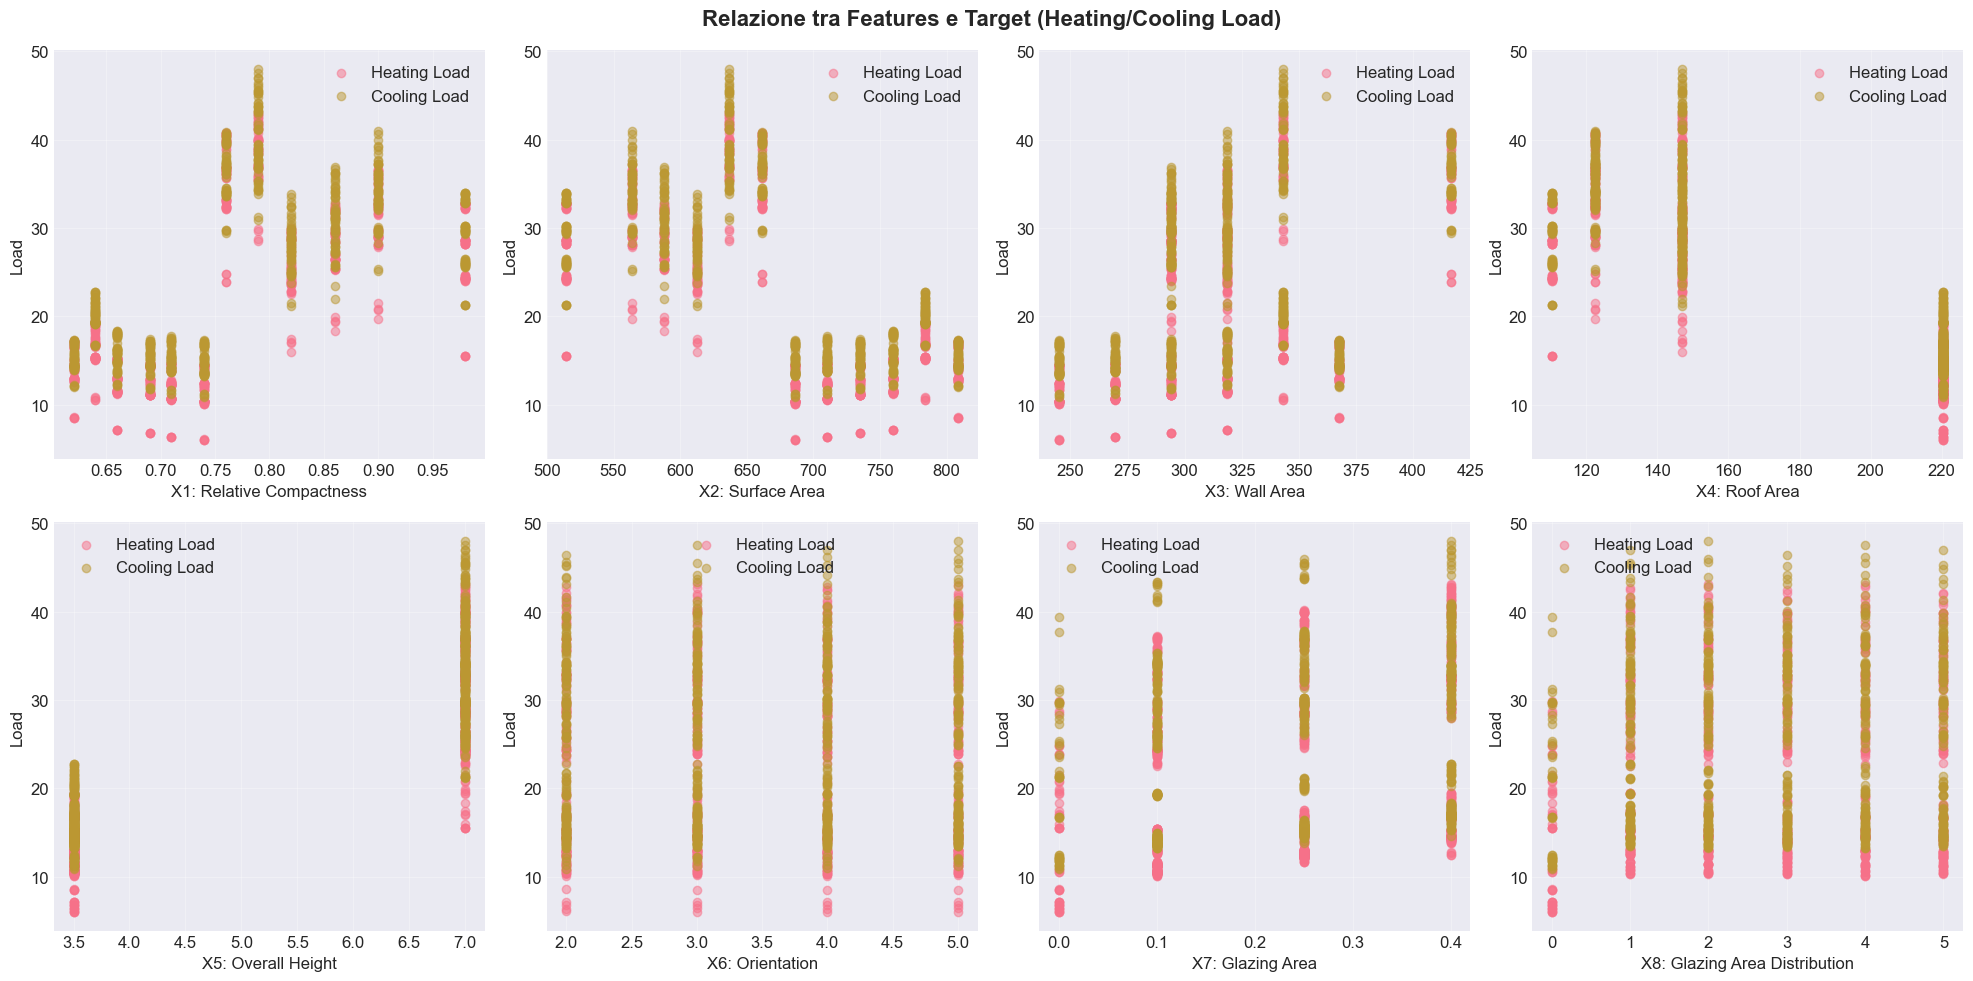

In [9]:
# Analisi delle relazioni tra features e target
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']

for i, feature in enumerate(features):
    axes[i].scatter(df[feature], df['Y1'], alpha=0.5, label='Heating Load')
    axes[i].scatter(df[feature], df['Y2'], alpha=0.5, label='Cooling Load')
    axes[i].set_xlabel(f'{feature}: {column_descriptions[feature]}')
    axes[i].set_ylabel('Load')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Relazione tra Features e Target (Heating/Cooling Load)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Preprocessing dei Dati per Clustering

In [10]:
# Decisione importante: includere o no Y1 e Y2 nel clustering?
print("📌 CONFIGURAZIONE DEL CLUSTERING")
print("="*50)

# Opzione 1: Solo features fisiche (X1-X8)
features_only = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].copy()

# Opzione 2: Features + targets (X1-X8 + Y1-Y2)
features_and_targets = df.copy()

# Per questo notebook useremo entrambi gli approcci
print("Analizzeremo due configurazioni:")
print("1. Solo features fisiche (X1-X8) - per raggruppare edifici simili strutturalmente")
print("2. Features + carichi energetici (X1-X8 + Y1-Y2) - per raggruppare edifici con comportamento energetico simile")

# Selezioniamo l'approccio 2 per l'analisi principale
data_for_clustering = features_and_targets
print(f"\n✅ Selezionato: Features + Targets per clustering completo")
print(f"   Shape dei dati: {data_for_clustering.shape}")

📌 CONFIGURAZIONE DEL CLUSTERING
Analizzeremo due configurazioni:
1. Solo features fisiche (X1-X8) - per raggruppare edifici simili strutturalmente
2. Features + carichi energetici (X1-X8 + Y1-Y2) - per raggruppare edifici con comportamento energetico simile

✅ Selezionato: Features + Targets per clustering completo
   Shape dei dati: (768, 10)


✅ Dati scalati con RobustScaler

Statistiche dopo scaling:
               X1          X2          X3          X4          X5          X6  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     0.096045   -0.015152    0.000000   -0.089744    0.000000    0.000000   
std      0.717135    0.653700    0.890336    0.567233    0.500326    0.745842   
min     -0.881356   -1.181818   -1.500000   -0.923077   -0.500000   -1.000000   
25%     -0.457627   -0.500000   -0.500000   -0.538462   -0.500000   -0.500000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.542373    0.500000    0.500000    0.461538    0.500000    0.500000   
max      1.559322    1.000000    2.000000    0.461538    0.500000    1.000000   

               X7          X8          Y1            Y2  
count  768.000000  768.000000  768.000000  7.680000e+02  
mean    -0.052083   -0.083333    0.179769  1.431983e-01  
std      0.444069    0.689315    0.54

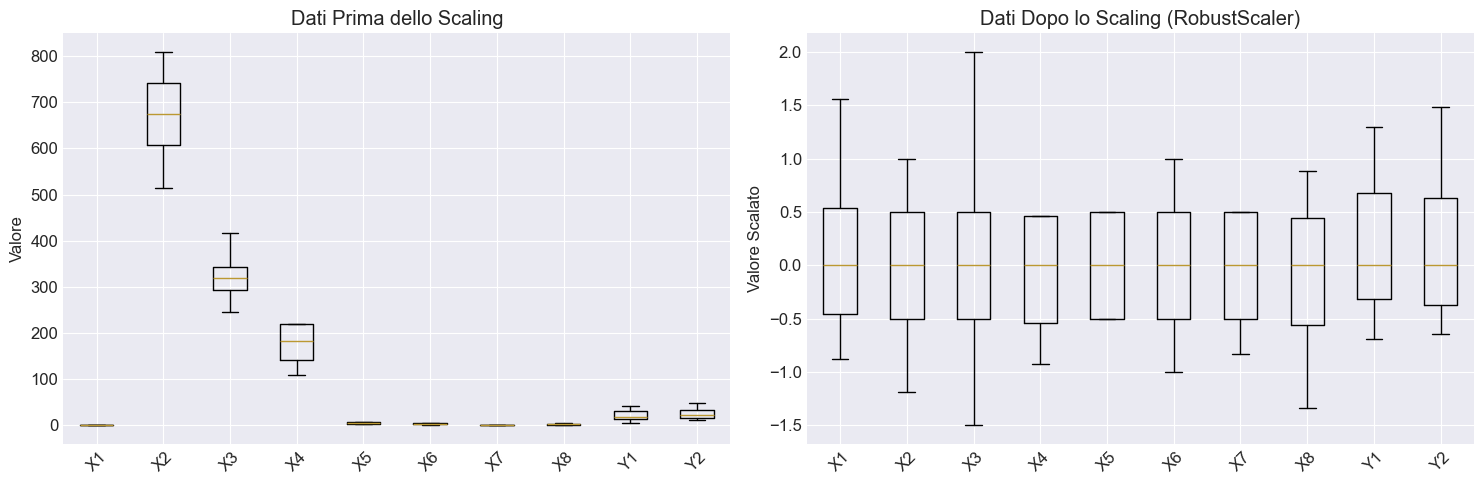

In [11]:
# Scaling dei dati
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Confronto tra diversi metodi di scaling
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler()
}

# Utilizziamo RobustScaler per gestire meglio eventuali outliers
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# Convertiamo in DataFrame per comodità
data_scaled_df = pd.DataFrame(data_scaled, columns=data_for_clustering.columns)

print("✅ Dati scalati con RobustScaler")
print("\nStatistiche dopo scaling:")
print(data_scaled_df.describe())

# Visualizzazione dell'effetto dello scaling
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Prima dello scaling
axes[0].boxplot([data_for_clustering[col] for col in data_for_clustering.columns], 
                labels=data_for_clustering.columns)
axes[0].set_title('Dati Prima dello Scaling')
axes[0].set_ylabel('Valore')
axes[0].tick_params(axis='x', rotation=45)

# Dopo lo scaling
axes[1].boxplot([data_scaled_df[col] for col in data_scaled_df.columns],
                labels=data_scaled_df.columns)
axes[1].set_title('Dati Dopo lo Scaling (RobustScaler)')
axes[1].set_ylabel('Valore Scalato')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# Rilevamento e gestione outliers
from scipy import stats

def detect_outliers_zscore(data, threshold=3):
    """Identifica outliers usando Z-score"""
    z_scores = np.abs(stats.zscore(data))
    outlier_indices = np.where(z_scores > threshold)
    return outlier_indices[0]

def detect_outliers_iqr(data):
    """Identifica outliers usando IQR"""
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    outlier_indices = np.where((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return np.unique(outlier_indices[0])

# Identifica outliers
outliers_zscore = detect_outliers_zscore(data_scaled)
outliers_iqr = detect_outliers_iqr(data_scaled)

print(f"📊 ANALISI OUTLIERS")
print("="*50)
print(f"Outliers rilevati con Z-score (threshold=3): {len(outliers_zscore)} ({len(outliers_zscore)/len(data_scaled)*100:.1f}%)")
print(f"Outliers rilevati con IQR: {len(outliers_iqr)} ({len(outliers_iqr)/len(data_scaled)*100:.1f}%)")
print("\n💡 Nota: RobustScaler è già robusto agli outliers, quindi non li rimuoveremo")

📊 ANALISI OUTLIERS
Outliers rilevati con Z-score (threshold=3): 0 (0.0%)
Outliers rilevati con IQR: 0 (0.0%)

💡 Nota: RobustScaler è già robusto agli outliers, quindi non li rimuoveremo


## 5. Applicazione di Metodi di Clustering Non Lineari

### 5.1 DBSCAN (Density-Based Spatial Clustering)

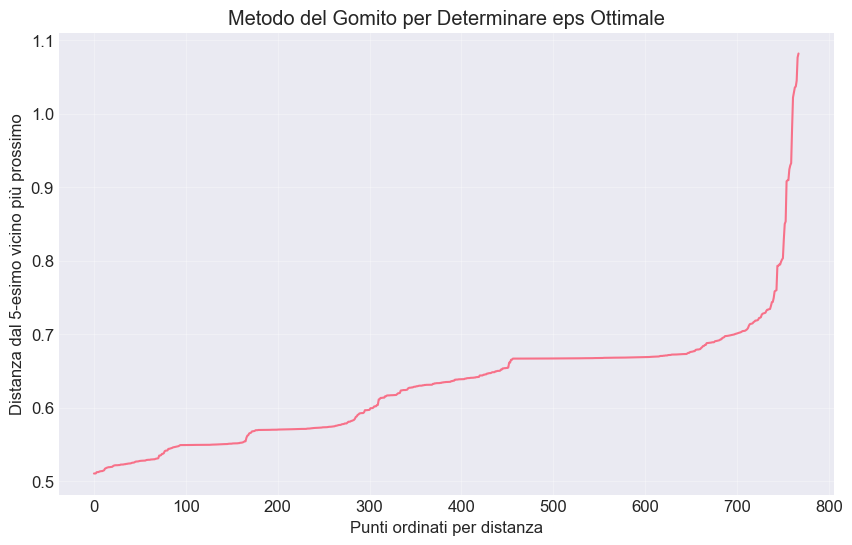


📍 eps ottimale stimato: 0.728


In [13]:
# DBSCAN con ottimizzazione dei parametri
from sklearn.neighbors import NearestNeighbors

# Metodo del gomito per determinare eps ottimale
def find_optimal_eps(data, min_samples=5):
    """Trova eps ottimale usando il metodo del gomito"""
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, min_samples-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Punti ordinati per distanza')
    plt.ylabel(f'Distanza dal {min_samples}-esimo vicino più prossimo')
    plt.title('Metodo del Gomito per Determinare eps Ottimale')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return distances

# Trova eps ottimale
distances = find_optimal_eps(data_scaled, min_samples=5)

# Basandosi sul grafico, scegliamo eps
# Nota: in un caso reale, questo valore andrebbe scelto interattivamente osservando il grafico
eps_optimal = np.percentile(distances, 95)  # Usiamo il 95° percentile come stima
print(f"\n📍 eps ottimale stimato: {eps_optimal:.3f}")

In [14]:
# Grid search per DBSCAN
from itertools import product

# Definisci griglia di parametri
eps_values = np.linspace(0.5, 3.0, 10)
min_samples_values = [3, 5, 7, 10, 15]

dbscan_results = []

print("🔍 Grid Search per DBSCAN in corso...")
for eps, min_samples in product(eps_values, min_samples_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data_scaled)
    
    # Calcola metriche solo se ci sono almeno 2 cluster (escludendo rumore)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters >= 2:
        # Filtra i punti rumorosi per il calcolo delle metriche
        mask = labels != -1
        if mask.sum() > 0:
            silhouette = silhouette_score(data_scaled[mask], labels[mask])
            davies_bouldin = davies_bouldin_score(data_scaled[mask], labels[mask])
            calinski = calinski_harabasz_score(data_scaled[mask], labels[mask])
        else:
            silhouette = davies_bouldin = calinski = -1
    else:
        silhouette = davies_bouldin = calinski = -1
    
    dbscan_results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski': calinski
    })

# Converti in DataFrame per analisi
dbscan_df = pd.DataFrame(dbscan_results)

# Trova migliori parametri (massimizza silhouette)
best_dbscan = dbscan_df[dbscan_df['silhouette'] > 0].nlargest(5, 'silhouette')
print("\n🏆 Top 5 configurazioni DBSCAN (per Silhouette Score):")
print(best_dbscan[['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette']].to_string())

🔍 Grid Search per DBSCAN in corso...

🏆 Top 5 configurazioni DBSCAN (per Silhouette Score):
         eps  min_samples  n_clusters  n_noise  silhouette
20  1.611111            3           2        0    0.391763
21  1.611111            5           2        0    0.391763
22  1.611111            7           2        0    0.391763
23  1.611111           10           2        0    0.391763
24  1.611111           15           2        0    0.391763


In [15]:
# Applica DBSCAN con i migliori parametri
if len(best_dbscan) > 0:
    best_params = best_dbscan.iloc[0]
    dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
    dbscan_labels = dbscan_final.fit_predict(data_scaled)
else:
    # Fallback con parametri di default
    dbscan_final = DBSCAN(eps=1.5, min_samples=5)
    dbscan_labels = dbscan_final.fit_predict(data_scaled)

# Analisi risultati DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

print("\n📊 RISULTATI DBSCAN FINALE:")
print("="*50)
print(f"Numero di cluster: {n_clusters_dbscan}")
print(f"Punti rumorosi: {n_noise_dbscan} ({n_noise_dbscan/len(dbscan_labels)*100:.1f}%)")

# Distribuzione dei cluster
unique, counts = np.unique(dbscan_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    if cluster == -1:
        print(f"  Rumore: {count} punti")
    else:
        print(f"  Cluster {cluster}: {count} punti")


📊 RISULTATI DBSCAN FINALE:
Numero di cluster: 2
Punti rumorosi: 0 (0.0%)
  Cluster 0: 384 punti
  Cluster 1: 384 punti


### 5.2 Spectral Clustering

In [16]:
# Spectral Clustering con ottimizzazione
n_clusters_range = range(2, 11)
spectral_results = []

print("🔍 Ottimizzazione Spectral Clustering in corso...")
for n_clusters in n_clusters_range:
    # Prova diversi parametri di affinità
    for affinity in ['nearest_neighbors', 'rbf']:
        try:
            if affinity == 'nearest_neighbors':
                spectral = SpectralClustering(n_clusters=n_clusters, 
                                             affinity=affinity,
                                             n_neighbors=10,
                                             random_state=42)
            else:
                spectral = SpectralClustering(n_clusters=n_clusters,
                                             affinity=affinity,
                                             gamma=1.0,
                                             random_state=42)
            
            labels = spectral.fit_predict(data_scaled)
            
            # Calcola metriche
            silhouette = silhouette_score(data_scaled, labels)
            davies_bouldin = davies_bouldin_score(data_scaled, labels)
            calinski = calinski_harabasz_score(data_scaled, labels)
            
            spectral_results.append({
                'n_clusters': n_clusters,
                'affinity': affinity,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski': calinski
            })
        except:
            continue

# Analisi risultati
spectral_df = pd.DataFrame(spectral_results)
best_spectral = spectral_df.nlargest(5, 'silhouette')

print("\n🏆 Top 5 configurazioni Spectral Clustering:")
print(best_spectral[['n_clusters', 'affinity', 'silhouette', 'davies_bouldin']].to_string())

🔍 Ottimizzazione Spectral Clustering in corso...

🏆 Top 5 configurazioni Spectral Clustering:
   n_clusters           affinity  silhouette  davies_bouldin
1           2                rbf    0.391763        1.119216
2           3  nearest_neighbors    0.373683        1.038347
3           3                rbf    0.373683        1.038347
5           4                rbf    0.317663        1.215421
4           4  nearest_neighbors    0.297624        1.443036


In [17]:
# Applica Spectral Clustering con i migliori parametri
best_spectral_params = best_spectral.iloc[0]
if best_spectral_params['affinity'] == 'nearest_neighbors':
    spectral_final = SpectralClustering(
        n_clusters=int(best_spectral_params['n_clusters']),
        affinity=best_spectral_params['affinity'],
        n_neighbors=10,
        random_state=42
    )
else:
    spectral_final = SpectralClustering(
        n_clusters=int(best_spectral_params['n_clusters']),
        affinity=best_spectral_params['affinity'],
        gamma=1.0,
        random_state=42
    )

spectral_labels = spectral_final.fit_predict(data_scaled)

print("\n📊 RISULTATI SPECTRAL CLUSTERING FINALE:")
print("="*50)
print(f"Numero di cluster: {len(np.unique(spectral_labels))}")
print(f"Silhouette Score: {silhouette_score(data_scaled, spectral_labels):.3f}")

# Distribuzione dei cluster
unique, counts = np.unique(spectral_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} punti")


📊 RISULTATI SPECTRAL CLUSTERING FINALE:
Numero di cluster: 2
Silhouette Score: 0.392
  Cluster 0: 384 punti
  Cluster 1: 384 punti


### 5.3 HDBSCAN (Hierarchical DBSCAN)

In [18]:
# HDBSCAN con ottimizzazione
min_cluster_size_range = [5, 10, 15, 20, 30]
min_samples_range = [1, 5, 10, 15]

hdbscan_results = []

print("🔍 Ottimizzazione HDBSCAN in corso...")
for min_cluster_size, min_samples in product(min_cluster_size_range, min_samples_range):
    try:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    metric='euclidean',
                                    cluster_selection_method='eom')
        labels = clusterer.fit_predict(data_scaled)
        
        # Numero di cluster (escludendo il rumore)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters >= 2:
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(data_scaled[mask], labels[mask])
                davies_bouldin = davies_bouldin_score(data_scaled[mask], labels[mask])
                calinski = calinski_harabasz_score(data_scaled[mask], labels[mask])
            else:
                silhouette = davies_bouldin = calinski = -1
        else:
            silhouette = davies_bouldin = calinski = -1
        
        hdbscan_results.append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski': calinski
        })
    except Exception as e:
        print(f"Errore con min_cluster_size={min_cluster_size}, min_samples={min_samples}: {e}")
        continue

# Analisi risultati
hdbscan_df = pd.DataFrame(hdbscan_results)
best_hdbscan = hdbscan_df[hdbscan_df['silhouette'] > 0].nlargest(5, 'silhouette')

print("\n🏆 Top 5 configurazioni HDBSCAN:")
print(best_hdbscan[['min_cluster_size', 'min_samples', 'n_clusters', 'n_noise', 'silhouette']].to_string())

🔍 Ottimizzazione HDBSCAN in corso...

🏆 Top 5 configurazioni HDBSCAN:
   min_cluster_size  min_samples  n_clusters  n_noise  silhouette
0                 5            1           3        0    0.373683
1                 5            5           3        0    0.373683
2                 5           10           3        0    0.373683
4                10            1           3        0    0.373683
5                10            5           3        0    0.373683


In [19]:
# Applica HDBSCAN con i migliori parametri
if len(best_hdbscan) > 0:
    best_hdbscan_params = best_hdbscan.iloc[0]
    hdbscan_final = hdbscan.HDBSCAN(
        min_cluster_size=int(best_hdbscan_params['min_cluster_size']),
        min_samples=int(best_hdbscan_params['min_samples']),
        metric='euclidean',
        cluster_selection_method='eom'
    )
else:
    # Fallback con parametri di default
    hdbscan_final = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)

hdbscan_labels = hdbscan_final.fit_predict(data_scaled)

# Analisi risultati
n_clusters_hdbscan = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise_hdbscan = list(hdbscan_labels).count(-1)

print("\n📊 RISULTATI HDBSCAN FINALE:")
print("="*50)
print(f"Numero di cluster: {n_clusters_hdbscan}")
print(f"Punti rumorosi: {n_noise_hdbscan} ({n_noise_hdbscan/len(hdbscan_labels)*100:.1f}%)")

# Distribuzione dei cluster
unique, counts = np.unique(hdbscan_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    if cluster == -1:
        print(f"  Rumore: {count} punti")
    else:
        print(f"  Cluster {cluster}: {count} punti")


📊 RISULTATI HDBSCAN FINALE:
Numero di cluster: 3
Punti rumorosi: 0 (0.0%)
  Cluster 0: 384 punti
  Cluster 1: 64 punti
  Cluster 2: 320 punti


## 6. Visualizzazione dei Risultati con t-SNE e UMAP

In [21]:
# Calcolo t-SNE per visualizzazione 2D
print("🔄 Calcolo t-SNE in corso (potrebbe richiedere qualche minuto)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
tsne_results = tsne.fit_transform(data_scaled)

# Calcolo UMAP per visualizzazione 2D
print("🔄 Calcolo UMAP in corso...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_results = umap_reducer.fit_transform(data_scaled)
print("✅ Riduzione dimensionale completata!")

🔄 Calcolo t-SNE in corso (potrebbe richiedere qualche minuto)...
🔄 Calcolo UMAP in corso...
✅ Riduzione dimensionale completata!



📊 VISUALIZZAZIONE CON t-SNE


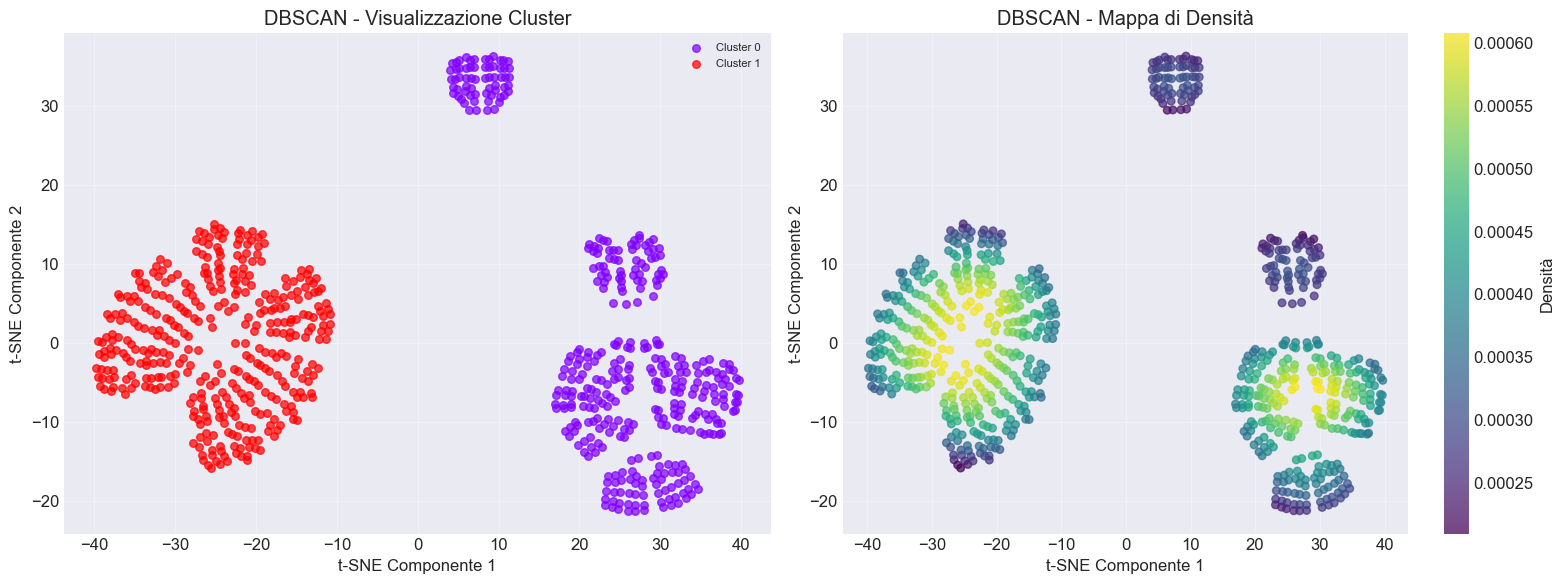

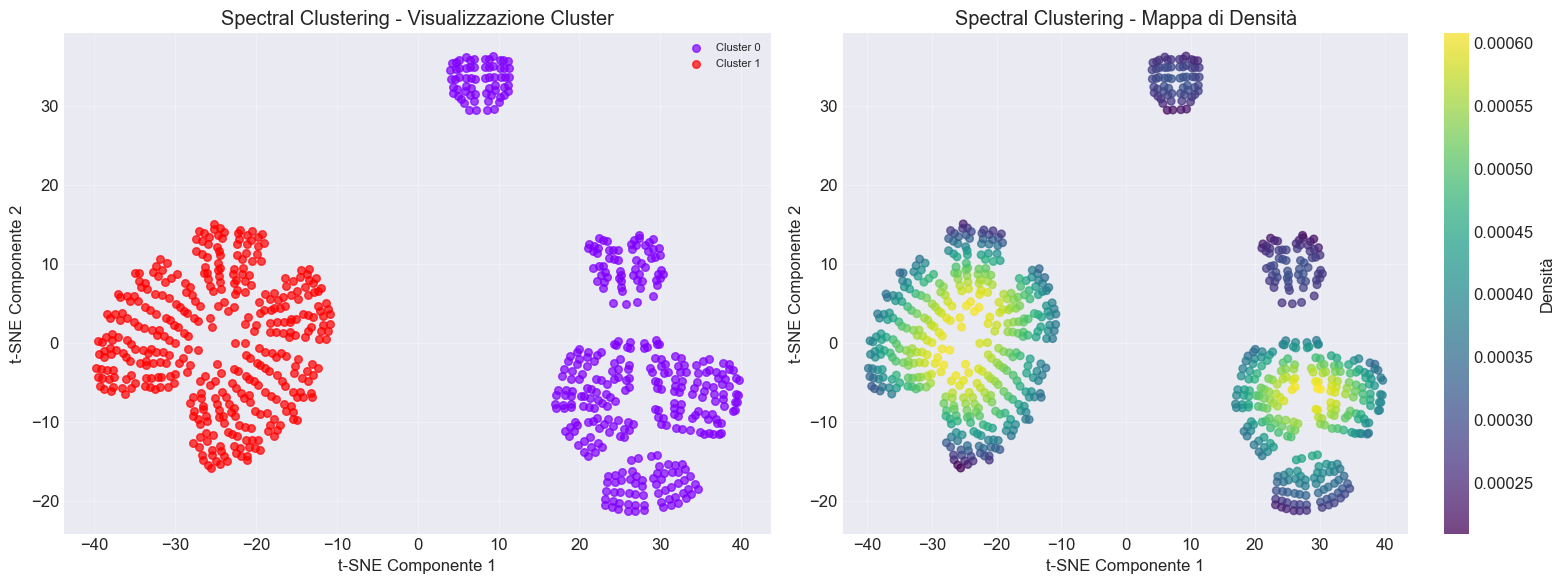

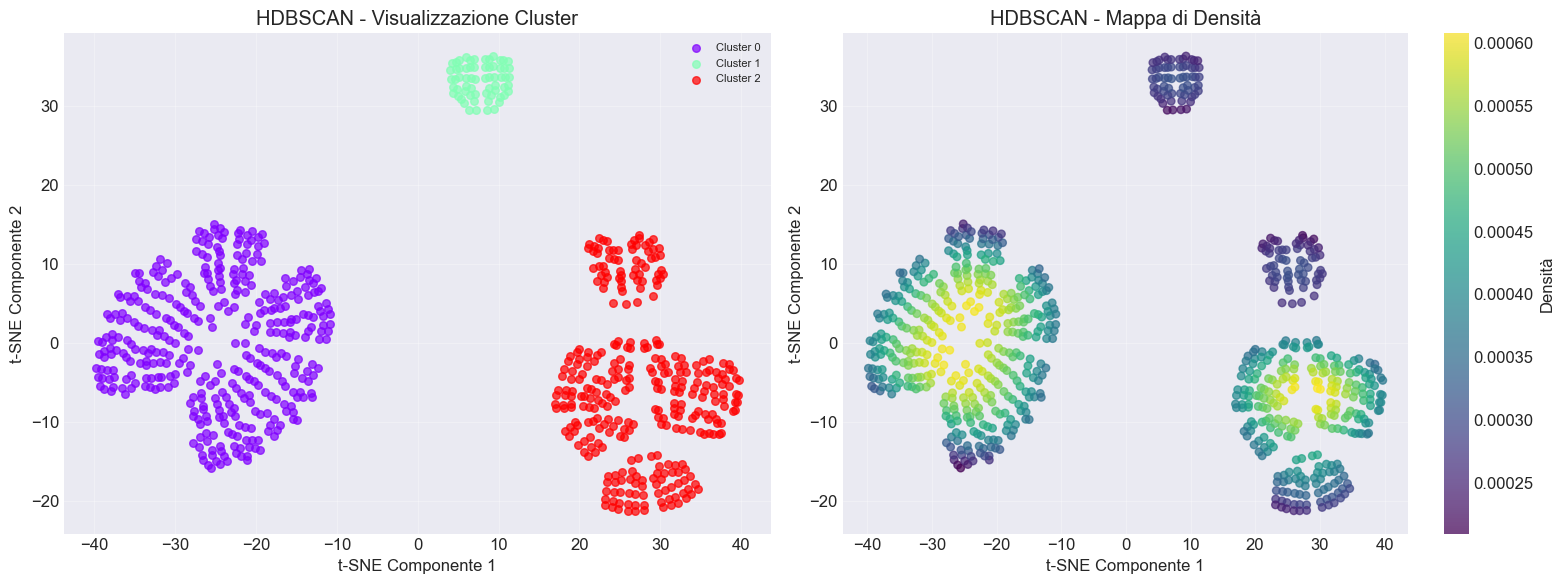


📊 VISUALIZZAZIONE CON UMAP


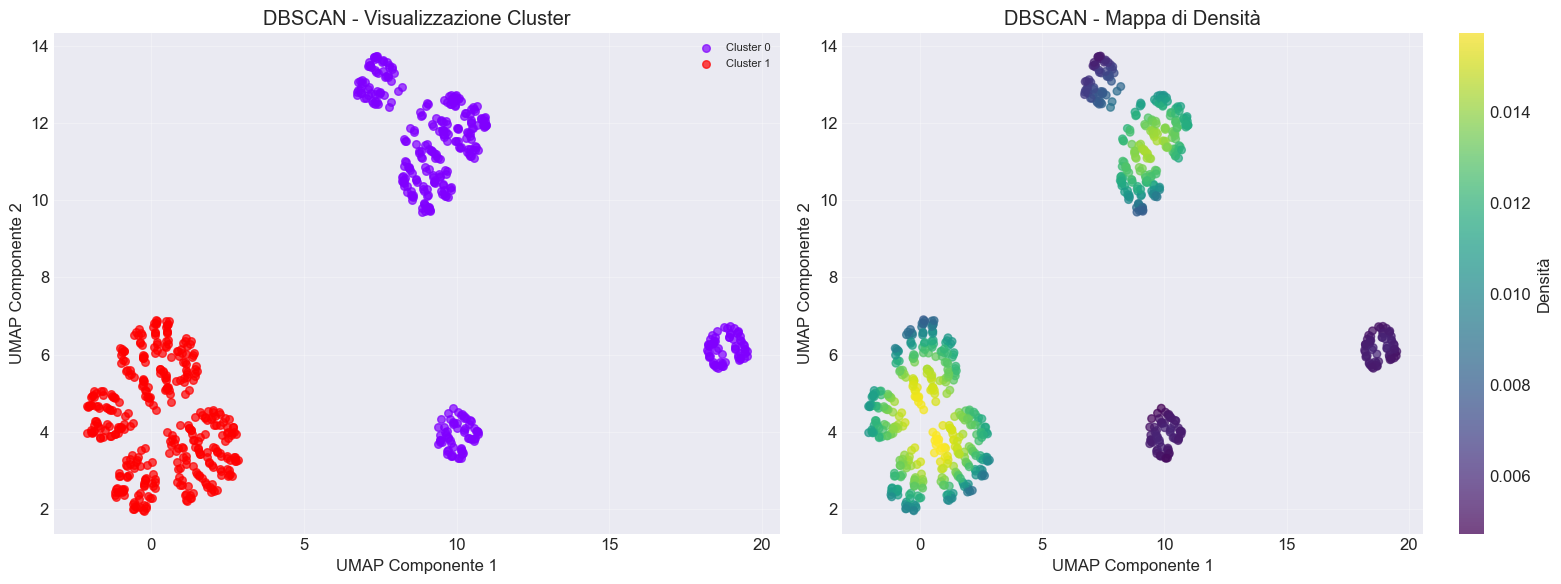

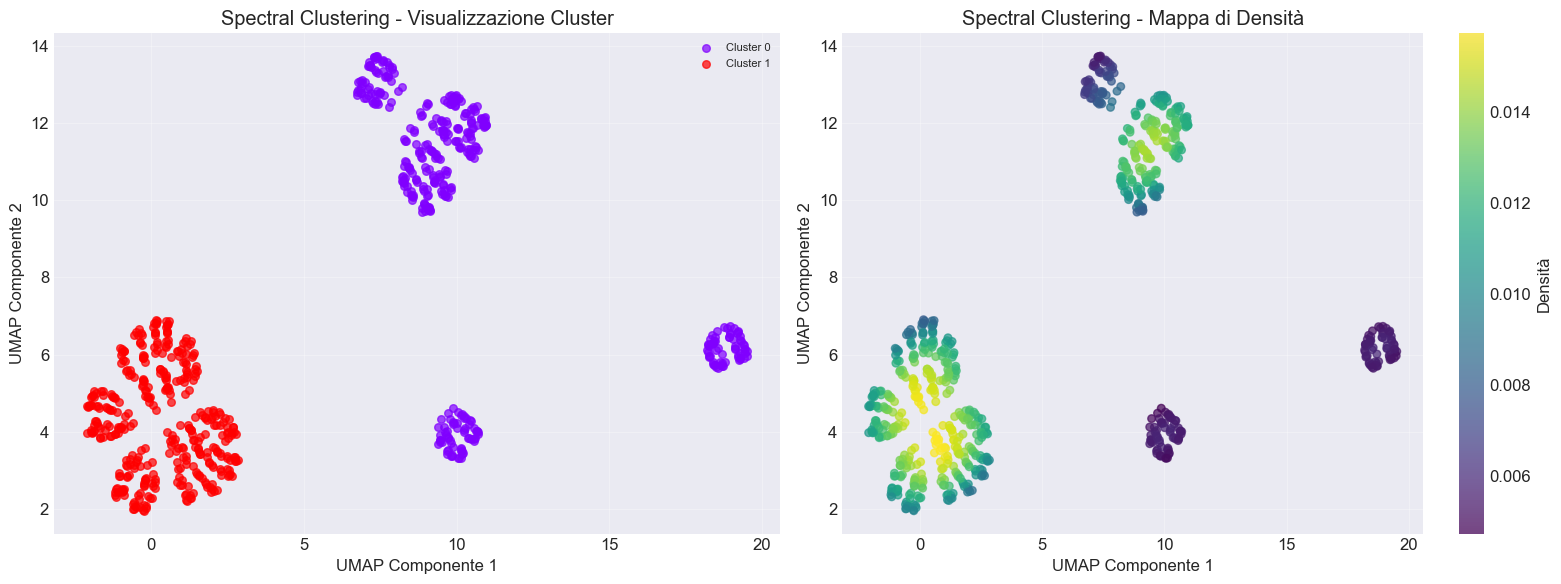

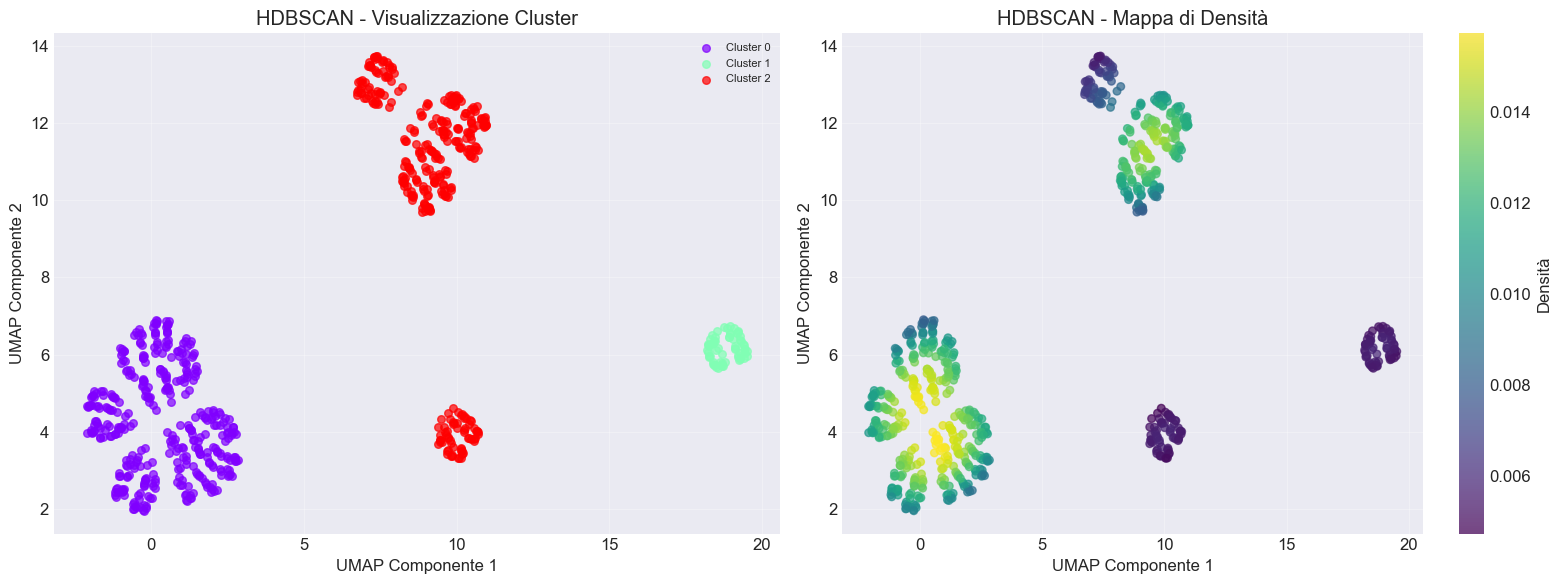

In [22]:
# Funzione per visualizzare i risultati del clustering
def plot_clustering_results(data_2d, labels, title, method_name):
    """Visualizza i risultati del clustering in 2D"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Colori per i cluster
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    # Plot 1: Cluster con colori
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        if label == -1:
            # Punti rumorosi in nero
            axes[0].scatter(data_2d[mask, 0], data_2d[mask, 1], 
                          c='black', s=10, alpha=0.3, label='Rumore')
        else:
            axes[0].scatter(data_2d[mask, 0], data_2d[mask, 1], 
                          c=[color], s=30, alpha=0.7, label=f'Cluster {label}')
    
    axes[0].set_title(f'{title} - Visualizzazione Cluster')
    axes[0].set_xlabel(f'{method_name} Componente 1')
    axes[0].set_ylabel(f'{method_name} Componente 2')
    axes[0].legend(loc='best', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Densità
    from scipy.stats import gaussian_kde
    
    # Rimuovi punti rumorosi per densità
    non_noise_mask = labels != -1
    if non_noise_mask.sum() > 0:
        xy = data_2d[non_noise_mask].T
        z = gaussian_kde(xy)(xy)
        scatter = axes[1].scatter(data_2d[non_noise_mask, 0], 
                                 data_2d[non_noise_mask, 1], 
                                 c=z, s=30, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, ax=axes[1], label='Densità')
    
    axes[1].set_title(f'{title} - Mappa di Densità')
    axes[1].set_xlabel(f'{method_name} Componente 1')
    axes[1].set_ylabel(f'{method_name} Componente 2')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualizza risultati per ogni metodo di clustering
clustering_methods = [
    ('DBSCAN', dbscan_labels),
    ('Spectral Clustering', spectral_labels),
    ('HDBSCAN', hdbscan_labels)
]

# Visualizzazione con t-SNE
print("\n📊 VISUALIZZAZIONE CON t-SNE")
print("="*50)
for method_name, labels in clustering_methods:
    plot_clustering_results(tsne_results, labels, method_name, 't-SNE')

# Visualizzazione con UMAP
print("\n📊 VISUALIZZAZIONE CON UMAP")
print("="*50)
for method_name, labels in clustering_methods:
    plot_clustering_results(umap_results, labels, method_name, 'UMAP')

## 7. Confronto delle Performance dei Metodi

In [23]:
# Calcolo metriche per confronto
def calculate_metrics(data, labels):
    """Calcola metriche di valutazione per il clustering"""
    # Filtra punti rumorosi se presenti
    mask = labels != -1
    if mask.sum() < 2:
        return {'silhouette': -1, 'davies_bouldin': -1, 'calinski': -1}
    
    filtered_data = data[mask]
    filtered_labels = labels[mask]
    
    # Verifica che ci siano almeno 2 cluster
    if len(np.unique(filtered_labels)) < 2:
        return {'silhouette': -1, 'davies_bouldin': -1, 'calinski': -1}
    
    return {
        'silhouette': silhouette_score(filtered_data, filtered_labels),
        'davies_bouldin': davies_bouldin_score(filtered_data, filtered_labels),
        'calinski': calinski_harabasz_score(filtered_data, filtered_labels)
    }

# Calcola metriche per ogni metodo
comparison_results = []

for method_name, labels in clustering_methods:
    metrics = calculate_metrics(data_scaled, labels)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    comparison_results.append({
        'Metodo': method_name,
        'N_Clusters': n_clusters,
        'N_Rumore': n_noise,
        'Silhouette': metrics['silhouette'],
        'Davies-Bouldin': metrics['davies_bouldin'],
        'Calinski-Harabasz': metrics['calinski']
    })

# Crea DataFrame per confronto
comparison_df = pd.DataFrame(comparison_results)

print("\n🏆 CONFRONTO DELLE PERFORMANCE DEI METODI DI CLUSTERING")
print("="*70)
print(comparison_df.to_string(index=False))
print("\n📌 Note sulle metriche:")
print("   - Silhouette: più alto è meglio (range: -1 a 1)")
print("   - Davies-Bouldin: più basso è meglio (minimo: 0)")
print("   - Calinski-Harabasz: più alto è meglio")


🏆 CONFRONTO DELLE PERFORMANCE DEI METODI DI CLUSTERING
             Metodo  N_Clusters  N_Rumore  Silhouette  Davies-Bouldin  Calinski-Harabasz
             DBSCAN           2         0    0.391763        1.119216         566.253623
Spectral Clustering           2         0    0.391763        1.119216         566.253623
            HDBSCAN           3         0    0.373683        1.038347         409.628742

📌 Note sulle metriche:
   - Silhouette: più alto è meglio (range: -1 a 1)
   - Davies-Bouldin: più basso è meglio (minimo: 0)
   - Calinski-Harabasz: più alto è meglio


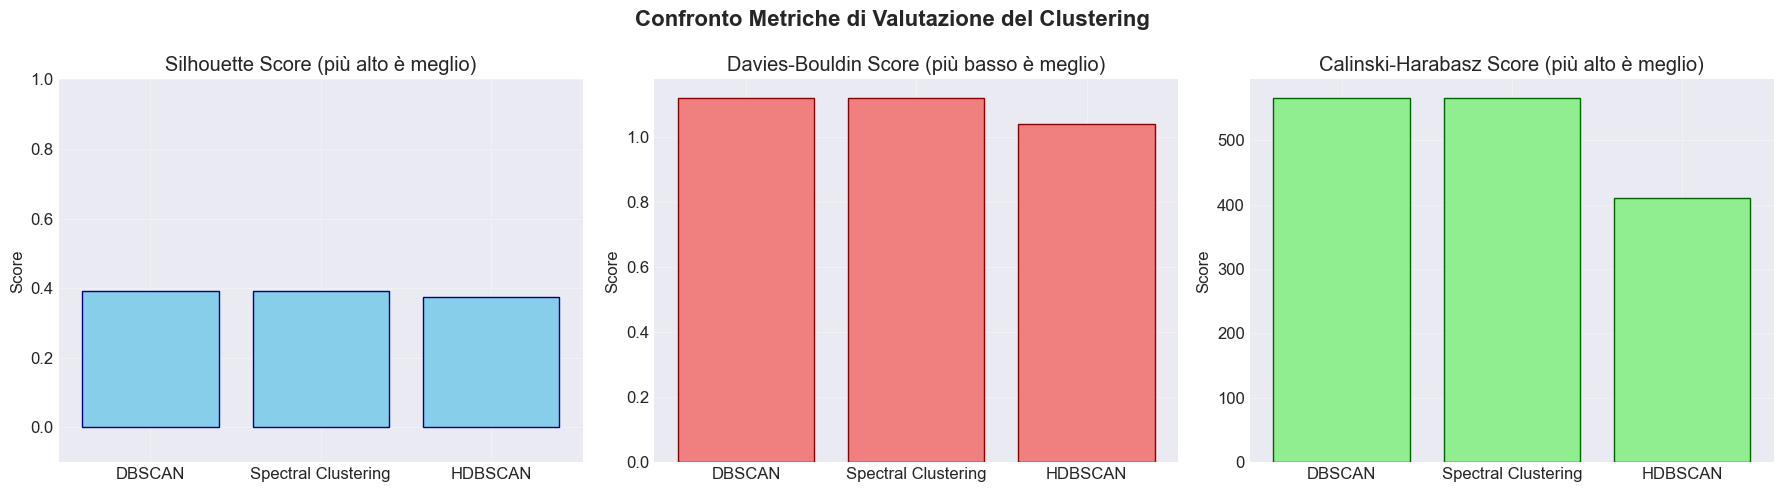

In [24]:
# Visualizzazione confronto metriche
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score
axes[0].bar(comparison_df['Metodo'], comparison_df['Silhouette'], color='skyblue', edgecolor='navy')
axes[0].set_title('Silhouette Score (più alto è meglio)')
axes[0].set_ylabel('Score')
axes[0].set_ylim([-0.1, 1])
axes[0].grid(True, alpha=0.3)

# Davies-Bouldin Score
axes[1].bar(comparison_df['Metodo'], comparison_df['Davies-Bouldin'], color='lightcoral', edgecolor='darkred')
axes[1].set_title('Davies-Bouldin Score (più basso è meglio)')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)

# Calinski-Harabasz Score
axes[2].bar(comparison_df['Metodo'], comparison_df['Calinski-Harabasz'], color='lightgreen', edgecolor='darkgreen')
axes[2].set_title('Calinski-Harabasz Score (più alto è meglio)')
axes[2].set_ylabel('Score')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Confronto Metriche di Valutazione del Clustering', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Interpretazione dei Cluster

In [25]:
# Selezioniamo il miglior metodo basato su Silhouette Score
best_method_idx = comparison_df['Silhouette'].idxmax()
best_method = comparison_df.loc[best_method_idx, 'Metodo']
best_labels = clustering_methods[best_method_idx][1]

print(f"\n🏆 Miglior metodo selezionato: {best_method}")
print(f"   Silhouette Score: {comparison_df.loc[best_method_idx, 'Silhouette']:.3f}")

# Aggiungi etichette cluster al dataset originale
df['Cluster'] = best_labels

# Analisi dei profili dei cluster
print("\n📊 PROFILI DEI CLUSTER")
print("="*70)

# Calcola statistiche per ogni cluster
cluster_profiles = []

for cluster in sorted(df['Cluster'].unique()):
    if cluster != -1:  # Escludi punti rumorosi
        cluster_data = df[df['Cluster'] == cluster]
        
        profile = {
            'Cluster': cluster,
            'N_Edifici': len(cluster_data),
            'Compattezza_Media': cluster_data['X1'].mean(),
            'Superficie_Media': cluster_data['X2'].mean(),
            'Area_Pareti_Media': cluster_data['X3'].mean(),
            'Area_Tetto_Media': cluster_data['X4'].mean(),
            'Altezza_Media': cluster_data['X5'].mean(),
            'Orientamento_Più_Comune': cluster_data['X6'].mode().values[0] if len(cluster_data['X6'].mode()) > 0 else cluster_data['X6'].mean(),
            'Area_Vetrata_Media': cluster_data['X7'].mean(),
            'Distribuzione_Vetrata_Più_Comune': cluster_data['X8'].mode().values[0] if len(cluster_data['X8'].mode()) > 0 else cluster_data['X8'].mean(),
            'Carico_Riscaldamento_Medio': cluster_data['Y1'].mean(),
            'Carico_Raffreddamento_Medio': cluster_data['Y2'].mean()
        }
        
        cluster_profiles.append(profile)

# Crea DataFrame dei profili
profiles_df = pd.DataFrame(cluster_profiles)
profiles_df = profiles_df.round(2)

print(profiles_df.to_string())


🏆 Miglior metodo selezionato: DBSCAN
   Silhouette Score: 0.392

📊 PROFILI DEI CLUSTER
   Cluster  N_Edifici  Compattezza_Media  Superficie_Media  Area_Pareti_Media  Area_Tetto_Media  Altezza_Media  Orientamento_Più_Comune  Area_Vetrata_Media  Distribuzione_Vetrata_Più_Comune  Carico_Riscaldamento_Medio  Carico_Raffreddamento_Medio
0        0        384               0.85            596.17             330.75            132.71            7.0                        2                0.23                                 1                       31.28                        33.10
1        1        384               0.68            747.25             306.25            220.50            3.5                        2                0.23                                 1                       13.34                        16.07


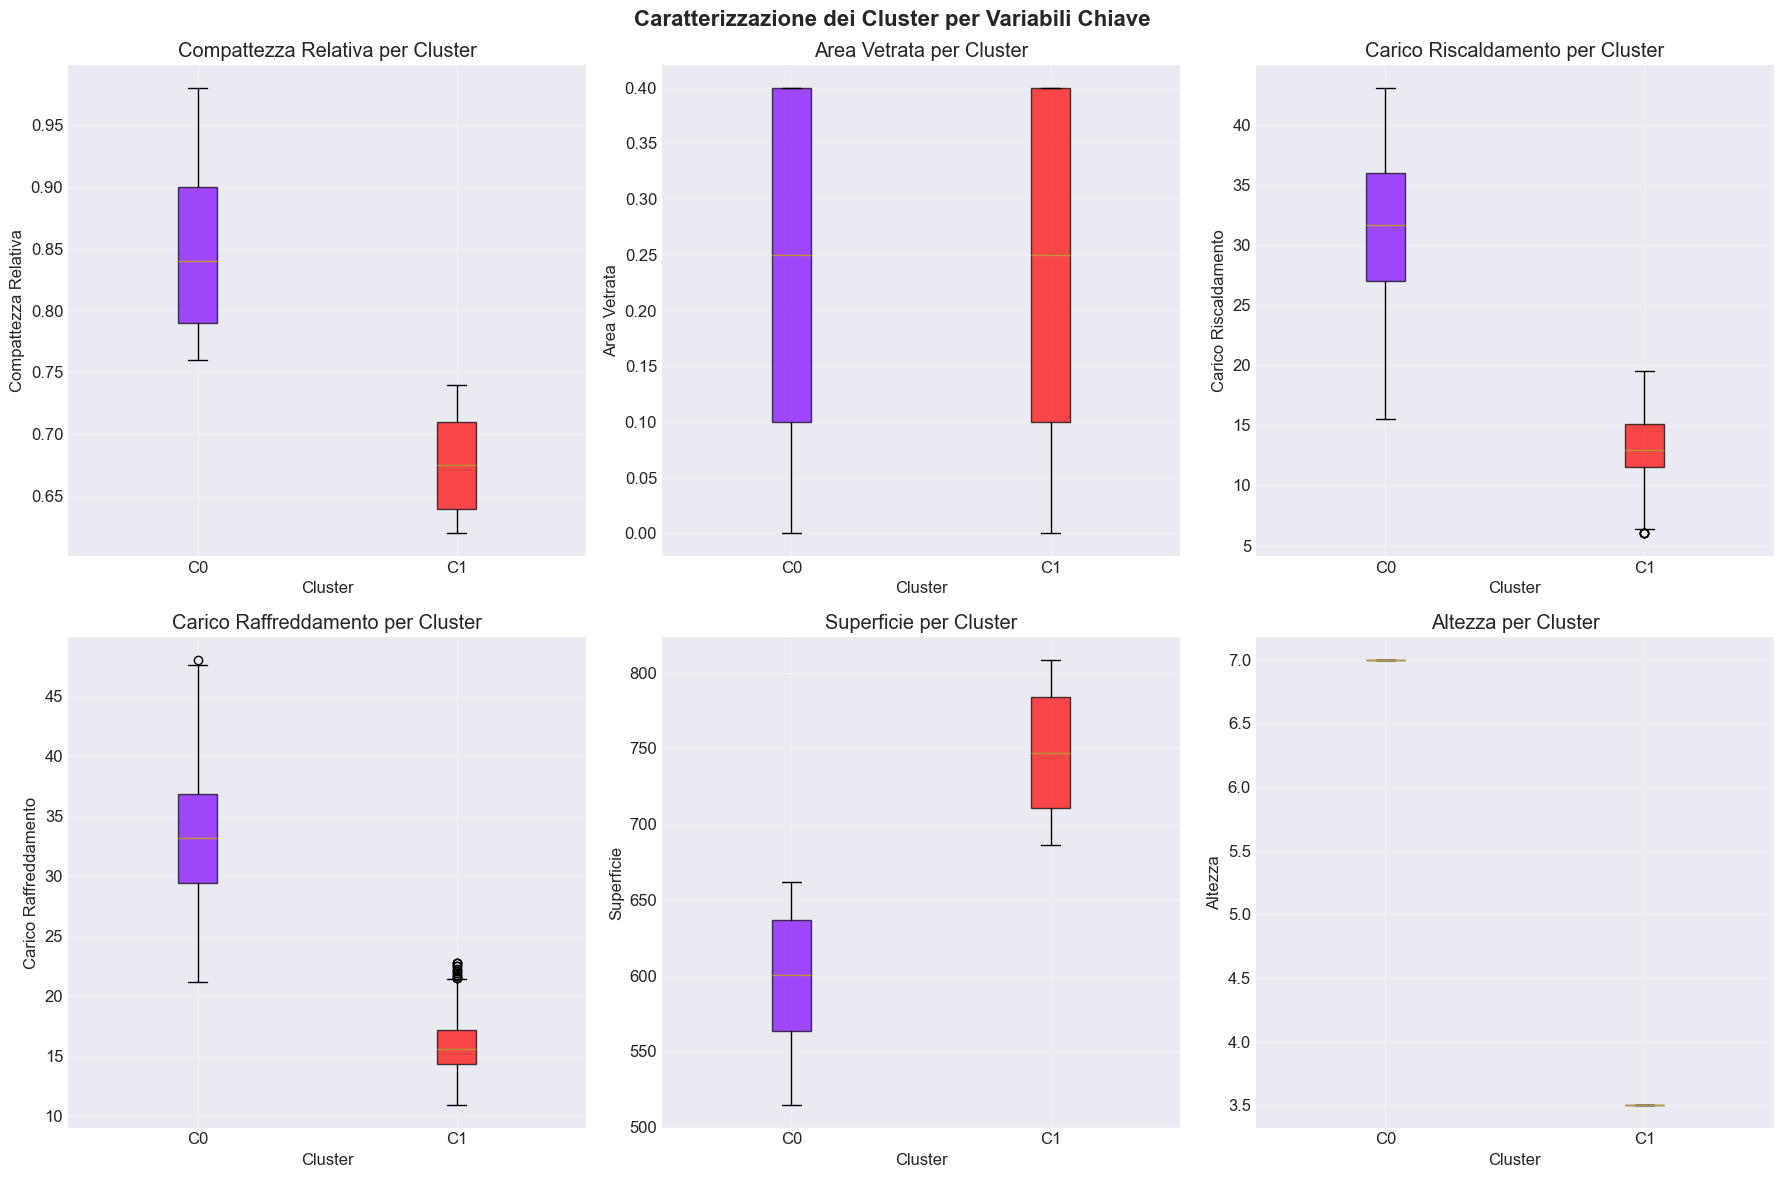

In [26]:
# Visualizzazione dei profili dei cluster
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Variabili chiave per la caratterizzazione
key_variables = [
    ('X1', 'Compattezza Relativa'),
    ('X7', 'Area Vetrata'),
    ('Y1', 'Carico Riscaldamento'),
    ('Y2', 'Carico Raffreddamento'),
    ('X2', 'Superficie'),
    ('X5', 'Altezza')
]

for idx, (var, title) in enumerate(key_variables):
    # Box plot per variabile per cluster
    cluster_data = []
    cluster_labels_plot = []
    
    for cluster in sorted(df['Cluster'].unique()):
        if cluster != -1:
            cluster_data.append(df[df['Cluster'] == cluster][var].values)
            cluster_labels_plot.append(f'C{cluster}')
    
    bp = axes[idx].boxplot(cluster_data, labels=cluster_labels_plot, patch_artist=True)
    
    # Colora i box plot
    colors = plt.cm.rainbow(np.linspace(0, 1, len(cluster_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_title(f'{title} per Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(title)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Caratterizzazione dei Cluster per Variabili Chiave', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [27]:
# Interpretazione qualitativa dei cluster
print("\n🔍 INTERPRETAZIONE QUALITATIVA DEI CLUSTER")
print("="*70)

for _, row in profiles_df.iterrows():
    cluster = int(row['Cluster'])
    print(f"\n📌 CLUSTER {cluster} ({int(row['N_Edifici'])} edifici):")
    print("-" * 50)
    
    # Caratteristiche fisiche
    if row['Compattezza_Media'] > 0.8:
        compact = "molto compatti"
    elif row['Compattezza_Media'] > 0.7:
        compact = "mediamente compatti"
    else:
        compact = "poco compatti"
    
    if row['Area_Vetrata_Media'] > 0.3:
        glazing = "ampia superficie vetrata"
    elif row['Area_Vetrata_Media'] > 0.15:
        glazing = "media superficie vetrata"
    else:
        glazing = "limitata superficie vetrata"
    
    # Prestazioni energetiche
    if row['Carico_Riscaldamento_Medio'] > 30:
        heating = "elevato fabbisogno di riscaldamento"
    elif row['Carico_Riscaldamento_Medio'] > 20:
        heating = "moderato fabbisogno di riscaldamento"
    else:
        heating = "basso fabbisogno di riscaldamento"
    
    if row['Carico_Raffreddamento_Medio'] > 30:
        cooling = "elevato fabbisogno di raffreddamento"
    elif row['Carico_Raffreddamento_Medio'] > 20:
        cooling = "moderato fabbisogno di raffreddamento"
    else:
        cooling = "basso fabbisogno di raffreddamento"
    
    print(f"\n💡 Caratteristiche principali:")
    print(f"   • Edifici {compact} con {glazing}")
    print(f"   • Superficie media: {row['Superficie_Media']:.0f} m²")
    print(f"   • Altezza prevalente: {row['Altezza_Media']:.1f} m")
    
    print(f"\n⚡ Prestazioni energetiche:")
    print(f"   • {heating.capitalize()} ({row['Carico_Riscaldamento_Medio']:.1f} kWh)")
    print(f"   • {cooling.capitalize()} ({row['Carico_Raffreddamento_Medio']:.1f} kWh)")
    
    # Raccomandazioni
    print(f"\n🎯 Raccomandazioni per efficienza energetica:")
    if row['Carico_Riscaldamento_Medio'] > 30:
        print(f"   • Priorità: migliorare isolamento termico")
    if row['Area_Vetrata_Media'] > 0.3 and row['Carico_Raffreddamento_Medio'] > 30:
        print(f"   • Considerare schermature solari o vetri a controllo solare")
    if row['Compattezza_Media'] < 0.7:
        print(f"   • Ottimizzare forma dell'edificio per ridurre dispersioni")
    if row['Carico_Riscaldamento_Medio'] < 20 and row['Carico_Raffreddamento_Medio'] < 20:
        print(f"   • Edifici già efficienti - focus su mantenimento prestazioni")


🔍 INTERPRETAZIONE QUALITATIVA DEI CLUSTER

📌 CLUSTER 0 (384 edifici):
--------------------------------------------------

💡 Caratteristiche principali:
   • Edifici molto compatti con media superficie vetrata
   • Superficie media: 596 m²
   • Altezza prevalente: 7.0 m

⚡ Prestazioni energetiche:
   • Elevato fabbisogno di riscaldamento (31.3 kWh)
   • Elevato fabbisogno di raffreddamento (33.1 kWh)

🎯 Raccomandazioni per efficienza energetica:
   • Priorità: migliorare isolamento termico

📌 CLUSTER 1 (384 edifici):
--------------------------------------------------

💡 Caratteristiche principali:
   • Edifici poco compatti con media superficie vetrata
   • Superficie media: 747 m²
   • Altezza prevalente: 3.5 m

⚡ Prestazioni energetiche:
   • Basso fabbisogno di riscaldamento (13.3 kWh)
   • Basso fabbisogno di raffreddamento (16.1 kWh)

🎯 Raccomandazioni per efficienza energetica:
   • Ottimizzare forma dell'edificio per ridurre dispersioni
   • Edifici già efficienti - focus su man

## 9. Conclusioni e Raccomandazioni

In [28]:
# Salvataggio risultati
print("\n💾 SALVATAGGIO RISULTATI")
print("="*50)

# Salva dataset con etichette cluster
output_filename = 'energy_efficiency_clustered.csv'
df.to_csv(output_filename, index=False)
print(f"✅ Dataset con cluster salvato: {output_filename}")

# Salva profili dei cluster
profiles_filename = 'cluster_profiles.csv'
profiles_df.to_csv(profiles_filename, index=False)
print(f"✅ Profili cluster salvati: {profiles_filename}")

# Salva confronto metriche
metrics_filename = 'clustering_metrics_comparison.csv'
comparison_df.to_csv(metrics_filename, index=False)
print(f"✅ Metriche di confronto salvate: {metrics_filename}")

print("\n📁 Tutti i risultati sono stati salvati con successo!")


💾 SALVATAGGIO RISULTATI
✅ Dataset con cluster salvato: energy_efficiency_clustered.csv
✅ Profili cluster salvati: cluster_profiles.csv
✅ Metriche di confronto salvate: clustering_metrics_comparison.csv

📁 Tutti i risultati sono stati salvati con successo!
